# Relating Carlson Symmetric Elliptic Integrals to the Weierstrass Elliptic Functions

This notebook contains an important new identity that was seemingly overlooked by Carlson when he derived his treatise on symmetric elliptic integrals. It relates the $R_j$ function to Weierstrass elliptic functions. Carlson had derived the corresponding relations for $R_F$ and $R_G$. The new relation does not appear in [NIST Handbook of Mathematical Functions](https://univ.jeanpaulcalvi.com/Posters/ConfAuchWeb/abramovitz2.pdf) or [NIST Digital Library of Mathematical Functions](https://dlmf.nist.gov/). This new relationship is likely a very important one as it involves the phase of a Kronecker theta function.

In [197]:
from sympy import *
(x, y, X, Y, Z, B, C, n, m, l, j, q, N, M, K, k, z, s, p1, p2, p3, g2, g3, rho,
 z0, z1, w1, w2, w3, e1, e2, e3, Delta, 
 omega1, omega2, omega3, eta1, eta2, eta3, d1, d2, d3, t, t0) = symbols(
    '''x, y, X, Y, Z, B, C, n, m, l, j, q, N, M, K, k, z, s, p1, p2, p3, g2, g3, rho,
    z0, z1, w1, w2, w3, e1, e2, e3, Delta, 
    omega1, omega2, omega3, eta1, eta2, eta3, d1, d2, d3, t, t0'''
)
alpha, delta, nu, theta = symbols('alpha, delta, nu, theta')
pw = Function('pw') # Weierstrass P function
pwp = Function('pwp') # Derivative of Weierstrass P function
zw = Function('zw') # Weierstrass Zeta function
sigma = Function('sigma') # Weierstrass Sigma function
rho = Function('rho')
f = Function('f')
h = Function('h')
s = Function('s')
u = Function('u')
v = Function('v')
r = Function('r')
chi = Function('chi')
P = Function('P') # Polynomial
Q = Function('Q') # Polynomial
R = Function('R') # Polynomial
T = Function('T') # Polynomial
phi = Function('phi')
Phi = Function('Phi')
phi1 = Function('phi1')
phi2 = Function('phi2')
phi3 = Function('phi3')
A = IndexedBase('A')
W1 = Function('W1')
W2 = Function('W2')
W3 = Function('W3')
W4 = Function('W4')
W5 = Function('W5')
W6 = Function('W6')
Det = Function("Det")
RF = Function('RF')
RJ = Function('RJ')
RG = Function('RG')


kappa = Function('kappa')
beta = IndexedBase('beta')

xi = IndexedBase('xi')
a = IndexedBase('a')
b = IndexedBase('b')
c = IndexedBase('c')
d = IndexedBase('d')
p = IndexedBase('p')
G = IndexedBase('G')
psi = IndexedBase('psi')
upsilon = IndexedBase('upsilon')
epsilon = IndexedBase('epsilon')
mu = IndexedBase('mu')
WPdet = Function('WPdet')
U = Function('U')
V = Function('V')
W = Function('W')

wild = Wild('*')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# kth order derivatives of Weierstrass P
from wpk import wpk, run_tests

# The package containing mpmath expressions for Weierstrass elliptic functions
from numerical_evaluation.weierstrass_modified import Weierstrass
we = Weierstrass()
from mpmath import exp as mpexp

# Nuemric solutions to diff eqs
from numpy import linspace, absolute, angle, square, real, imag, conj, array as arraynp, concatenate
from numpy import vectorize as np_vectorize # not to get confused with vectorise in other packages
import scipy.integrate
import matplotlib.pyplot as plt
from scipy.special import elliprf, elliprg, elliprj

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Numerical Evaluation

In [314]:
def mpc_to_float(mpc_val):
    return float(mpc_val.real) + float(mpc_val.imag)*1j

def wrap_I_to_j(f):
    """
    Wraps any function that takes positional arguments and converts those arguments from the form 1+2*I to 1+2j
    """
    def wrapped_function(*args):
        # Convert all arguments to python complex type
        new_args = [complex(str(arg).replace(' ','').replace('*','').replace('I', 'j')) for arg in args]
        # Call the original function with converted arguments
        return f(*new_args)
    
    return wrapped_function

def get_value_weierstrass_carlson_expression(side_of_expression, values):
    num_sub_evals = [
        (sigma, we.wsigma_from_g2_g3),
        (zw, we.wzeta_from_g2_g3),
        (pw, we.wp_from_g2_g3),
        (pwp, we.wpprime_from_g2_g3),
        (RF, wrap_I_to_j(elliprf)),
        (RG, wrap_I_to_j(elliprg)),
        (RJ, wrap_I_to_j(elliprj)),
        # Repeat the list in case of functions of functions
        (sigma, we.wsigma_from_g2_g3),
        (zw, we.wzeta_from_g2_g3),
        (pw, we.wp_from_g2_g3),
        (pwp, we.wpprime_from_g2_g3),
        (RF, wrap_I_to_j(elliprf)),
        (RG, wrap_I_to_j(elliprg)),
        (RJ, wrap_I_to_j(elliprj))
    ]
    eval_result = side_of_expression.subs(values)
    for num_eval in num_sub_evals:
        try:
            eval_result = eval_result.replace(*num_eval)
        except:
            pass
    return eval_result

def num_evaluate_weierstrass_carlson(expression, values, show_expression=True):

    lhs_value = get_value_weierstrass_carlson_expression(expression.lhs, values)
    rhs_value = get_value_weierstrass_carlson_expression(expression.rhs, values)    
    try:
        lhs_value = lhs_value.evalf()
    except:
        pass
    try:
        rhs_value = rhs_value.evalf()
    except:
        pass
        
    print('LHS', lhs_value)
    print('RHS', rhs_value)
    # Symmetric Mean Absolute Percentage Error (SMAPE)
    print('ERROR (SMAPE)', abs(lhs_value - rhs_value) * 2/(abs(lhs_value) + abs(rhs_value)))
    
    if show_expression:
        return expression
    
def plot_lattice(omega1, omega2, omega3, n_points=5):
    """
    Plots the lattice for two generators omega1 and omega3
    """
    
    # Generate lattice points
    points = []
    for i in range(-n_points, n_points+1):
        for j in range(-n_points, n_points+1):
            point = i * omega1 + j * omega3
            points.append(point)
    
    # Separate real and imaginary parts
    x_coords = [p.real for p in points]
    y_coords = [p.imag for p in points]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot lattice points
    ax.scatter(x_coords, y_coords, color='blue', s=30, label='Lattice Points')
    
    # Plot generators
    ax.arrow(0, 0, omega1.real, omega1.imag, color='red', width=0.02, length_includes_head=True, label='omega1')
    ax.arrow(0, 0, omega2.real, omega2.imag, color='blue', width=0.02, length_includes_head=True, label='omega2')
    ax.arrow(0, 0, omega3.real, omega3.imag, color='green', width=0.02, length_includes_head=True, label='omega3')
    
    # Set labels and title
    ax.set_xlabel('Re')
    ax.set_ylabel('Im')
    ax.set_title('Lattice Plot')
    
    # Set aspect ratio to equal
    ax.set_aspect('equal', adjustable='box')
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.grid(True)
    plt.show()



## Weierstrass elliptic function identities

In [3]:
pwp_sqrd = Eq(pwp(z,g2,g3)**2, 4*pw(z,g2,g3)**3 - g2*pw(z,g2,g3) - g3)

pw_xy_addition = Eq(pw(x+y,g2,g3), 
   ((pwp(x, g2, g3) - pwp(y, g2, g3))**2/(pw(x, g2, g3) - pw(y, g2, g3))**2)/4 - pw(x, g2, g3) - pw(y, g2, g3)
)
p_duplication_a = Eq(pw(2*z,g2,g3), -2*pw(z,g2,g3) + ((diff(pw(z,g2,g3),z,2)/diff(pw(z,g2,g3),z,1))**2)/4)
p_duplication_b = Eq(pw(2*z, g2, g3), (-g2/2 + 6*pw(z, g2, g3)**2)**2/(4*pwp(z, g2, g3)**2) - 2*pw(z, g2, g3))
p_duplication_c = p_duplication_b.subs(pwp(z,g2,g3)**2, 4*pw(z,g2,g3)**3 - g2*pw(z,g2,g3) - g3)

sigma_p_identity = Eq(
    pw(y, g2, g3) - pw(x, g2, g3),
    sigma(x + y, g2, g3) * sigma(x - y, g2, g3) / (sigma(x, g2, g3) ** 2 * sigma(y, g2, g3) ** 2) 
)

pw_to_zw_identity = Eq(
    (pwp(x,g2,g3) - pwp(y,g2,g3))/(pw(x,g2,g3) - pw(y,g2,g3))/2,
    zw(x + y,g2, g3) - zw(x,g2, g3) - zw(y,g2, g3)
)

# 23.10.9 https://dlmf.nist.gov/23.10#E9
zw2z_2zwz = Eq(zw(2*z,g2,g3), 2*zw(z,g2,g3) + diff(zw(z,g2,g3),z,3)/diff(zw(z,g2,g3),z,2)/2)
dzw_2 = Eq(diff(zw(z,g2,g3),z,2), -pwp(z,g2,g3))
dzw_3 = Eq(diff(zw(z,g2,g3),z,3), -diff(pwp(z,g2,g3),z))
pwp_def = Eq(pwp(z,g2,g3)**2, 4*pw(z,g2,g3)**3 - g2*pw(z,g2,g3) - g3)
pwp2_def = Eq(diff(pwp_def.lhs,z)/pwp(z,g2,g3)/2, 
              diff(pwp_def.rhs,z).subs(diff(pw(z,g2,g3),z),pwp(z,g2,g3))/pwp(z,g2,g3)/2).expand()
zw2z_2zwz_pw_pwp = zw2z_2zwz.subs([dzw_3.args, dzw_2.args]).subs(*pwp2_def.args)

pwp_sigma_dbl_ratio = Eq(pwp(z,g2,g3), - sigma(2*z,g2,g3)/sigma(z,g2,g3)**4)
d_zw_pw = Eq(diff(zw(z,g2,g3),z), -pw(z,g2,g3))
d_log_sigma_zw = Eq(Derivative(ln(sigma(z,g2,g3)),z), zw(z,g2,g3))
d_sigma_zw = Eq(diff(sigma(z,g2,g3),z), solve(d_log_sigma_zw.doit(), diff(sigma(z,g2,g3),z))[0])
d_sigma_zw_2 = Eq(diff(d_sigma_zw.lhs,z), diff(d_sigma_zw.rhs,z).subs([d_sigma_zw.args, d_zw_pw.args]))
pw_diff_at_zero = Eq(Limit(Derivative(pw(z, g2, g3), (z, j)), z, 0, dir='+'),
 (-1)**j*z**(-j - 2)*factorial(j + 1) - 
                     (-1)**j*((-1)**j/2 + Rational(1,2))*RisingFactorial(-j - 1, j + 1)*G[j + 2])


expansion_z_wp = Eq(pw(z,g2,g3), 1/z**2 + Sum((2*n+1)*G[2*n+2]*z**(2*n),(n,1,oo)))
one_over_sigma_z_big_o = Eq(1/sigma(z,g2,g3), (1/z*(1 - (- g2*z**4/10 - 6*g3/7*z**6 + O(z**8)))).expand())
sigma_expansion_g_2_3 = Eq(sigma(z, g2, g3),
    85860*g2**2*g3**2*z**21/7 + 171*g2**2*g3*z**15/10 - g2**2*z**9/4 + 
    9936*g2*g3**2*z**17/17 - 18*g2*g3*z**11/11 - g2*z**5/10 - 
    216*g3**2*z**13/13 - 6*g3*z**7/7 + z
)

quasi_period = Eq(sigma(2*m*omega3 + 2*n*omega1 + z, g2, g3),
 (-1)**(m*n + m + n)*sigma(z, g2, g3)*
                  exp(2*eta1*m*n*omega3 + 2*eta1*n**2*omega1 + 2*eta1*n*z + 
                      2*eta3*m**2*omega3 + 2*eta3*m*n*omega1 + 2*eta3*m*z)
                 )



taylor_series = Eq(f(x), Sum(Derivative(f(x),(x,n)).subs(x,a)/factorial(n) * (x - a)**n, (n,0,N)))
taylor_series_b = taylor_series.subs(x,x+a)

log_sigma_xy_a = Eq(Derivative(log(sigma(x+y,g2,g3)/sigma(y,g2,g3)),y), zw(x+y,g2,g3) - zw(y,g2,g3))
log_sigma_xy_b = Eq(Derivative(log(sigma(x+y,g2,g3)/sigma(y,g2,g3)*exp(-zw(x,g2,g3)*y)),y), 
   -zw(x, g2, g3) + zw(x+y,g2,g3) - zw(y,g2,g3))

pwp_x_y_log_sigma_diff = Eq(pwp(x, g2, g3)/((pw(x, g2, g3) - pw(y, g2, g3))),
 2*Derivative(log(sigma(x+y,g2,g3)/sigma(y,g2,g3)*exp(-zw(x,g2,g3)*y)),y) 
   - Derivative(log(pw(x,g2,g3) - pw(y,g2,g3)),y)
  )

pwp_x_y_log_sigma_diff_b = Eq(pwp_x_y_log_sigma_diff.lhs,
 2*Derivative(log(sigma(x + y, g2, g3)*exp(-y*zw(x, g2, g3))/sigma(y, g2, g3)/sigma(x, g2, g3)), y) - 
   Derivative(log(sigma(x + y, g2, g3)*exp(-y*zw(x, g2, g3))/
                  (sigma(x, g2, g3)*sigma(y, g2, g3))), y)-
   Derivative(log(sigma(-x + y, g2, g3)*exp(y*zw(x, g2, g3))/
                  (sigma(x, g2, g3)*sigma(y, g2, g3))), y)
  
)
log_sigma_xy_phase = log(sigma(x + y, g2, g3)*exp(-2*y*zw(x, g2, g3))/sigma(-x + y, g2, g3))
pwp_x_y_log_sigma_diff_c = Eq(pwp(x, g2, g3)/(pw(x, g2, g3) - pw(y, g2, g3)), Derivative(log_sigma_xy_phase, y))


pwp_sqrd
pw_xy_addition
p_duplication_a
p_duplication_b
p_duplication_c
sigma_p_identity
pw_to_zw_identity
zw2z_2zwz_pw_pwp
pwp_sigma_dbl_ratio
d_zw_pw
d_log_sigma_zw
d_sigma_zw
d_sigma_zw_2

pw_diff_at_zero
expansion_z_wp
one_over_sigma_z_big_o
sigma_expansion_g_2_3
quasi_period

pw_to_zw_identity
log_sigma_xy_a
log_sigma_xy_b
pwp_x_y_log_sigma_diff
pwp_x_y_log_sigma_diff_b
pwp_x_y_log_sigma_diff_c

taylor_series_b

Eq(pwp(z, g2, g3)**2, -g2*pw(z, g2, g3) - g3 + 4*pw(z, g2, g3)**3)

Eq(pw(x + y, g2, g3), -pw(x, g2, g3) - pw(y, g2, g3) + (pwp(x, g2, g3) - pwp(y, g2, g3))**2/(4*(pw(x, g2, g3) - pw(y, g2, g3))**2))

Eq(pw(2*z, g2, g3), -2*pw(z, g2, g3) + Derivative(pw(z, g2, g3), (z, 2))**2/(4*Derivative(pw(z, g2, g3), z)**2))

Eq(pw(2*z, g2, g3), (-g2/2 + 6*pw(z, g2, g3)**2)**2/(4*pwp(z, g2, g3)**2) - 2*pw(z, g2, g3))

Eq(pw(2*z, g2, g3), (-g2/2 + 6*pw(z, g2, g3)**2)**2/(4*(-g2*pw(z, g2, g3) - g3 + 4*pw(z, g2, g3)**3)) - 2*pw(z, g2, g3))

Eq(-pw(x, g2, g3) + pw(y, g2, g3), sigma(x - y, g2, g3)*sigma(x + y, g2, g3)/(sigma(x, g2, g3)**2*sigma(y, g2, g3)**2))

Eq((pwp(x, g2, g3) - pwp(y, g2, g3))/(2*(pw(x, g2, g3) - pw(y, g2, g3))), -zw(x, g2, g3) - zw(y, g2, g3) + zw(x + y, g2, g3))

Eq(zw(2*z, g2, g3), (-g2/2 + 6*pw(z, g2, g3)**2)/(2*pwp(z, g2, g3)) + 2*zw(z, g2, g3))

Eq(pwp(z, g2, g3), -sigma(2*z, g2, g3)/sigma(z, g2, g3)**4)

Eq(Derivative(zw(z, g2, g3), z), -pw(z, g2, g3))

Eq(Derivative(log(sigma(z, g2, g3)), z), zw(z, g2, g3))

Eq(Derivative(sigma(z, g2, g3), z), sigma(z, g2, g3)*zw(z, g2, g3))

Eq(Derivative(sigma(z, g2, g3), (z, 2)), -pw(z, g2, g3)*sigma(z, g2, g3) + sigma(z, g2, g3)*zw(z, g2, g3)**2)

Eq(Limit(Derivative(pw(z, g2, g3), (z, j)), z, 0, dir='+'), (-1)**j*z**(-j - 2)*factorial(j + 1) - (-1)**j*((-1)**j/2 + 1/2)*RisingFactorial(-j - 1, j + 1)*G[j + 2])

Eq(pw(z, g2, g3), Sum(z**(2*n)*(2*n + 1)*G[2*n + 2], (n, 1, oo)) + z**(-2))

Eq(1/sigma(z, g2, g3), 1/z + 6*g3*z**5/7 + g2*z**3/10 + O(z**7))

Eq(sigma(z, g2, g3), 85860*g2**2*g3**2*z**21/7 + 171*g2**2*g3*z**15/10 - g2**2*z**9/4 + 9936*g2*g3**2*z**17/17 - 18*g2*g3*z**11/11 - g2*z**5/10 - 216*g3**2*z**13/13 - 6*g3*z**7/7 + z)

Eq(sigma(2*m*omega3 + 2*n*omega1 + z, g2, g3), (-1)**(m*n + m + n)*sigma(z, g2, g3)*exp(2*eta1*m*n*omega3 + 2*eta1*n**2*omega1 + 2*eta1*n*z + 2*eta3*m**2*omega3 + 2*eta3*m*n*omega1 + 2*eta3*m*z))

Eq((pwp(x, g2, g3) - pwp(y, g2, g3))/(2*(pw(x, g2, g3) - pw(y, g2, g3))), -zw(x, g2, g3) - zw(y, g2, g3) + zw(x + y, g2, g3))

Eq(Derivative(log(sigma(x + y, g2, g3)/sigma(y, g2, g3)), y), -zw(y, g2, g3) + zw(x + y, g2, g3))

Eq(Derivative(log(sigma(x + y, g2, g3)*exp(-y*zw(x, g2, g3))/sigma(y, g2, g3)), y), -zw(x, g2, g3) - zw(y, g2, g3) + zw(x + y, g2, g3))

Eq(pwp(x, g2, g3)/(pw(x, g2, g3) - pw(y, g2, g3)), 2*Derivative(log(sigma(x + y, g2, g3)*exp(-y*zw(x, g2, g3))/sigma(y, g2, g3)), y) - Derivative(log(pw(x, g2, g3) - pw(y, g2, g3)), y))

Eq(pwp(x, g2, g3)/(pw(x, g2, g3) - pw(y, g2, g3)), -Derivative(log(sigma(-x + y, g2, g3)*exp(y*zw(x, g2, g3))/(sigma(x, g2, g3)*sigma(y, g2, g3))), y) + Derivative(log(sigma(x + y, g2, g3)*exp(-y*zw(x, g2, g3))/(sigma(x, g2, g3)*sigma(y, g2, g3))), y))

Eq(pwp(x, g2, g3)/(pw(x, g2, g3) - pw(y, g2, g3)), Derivative(log(sigma(x + y, g2, g3)*exp(-2*y*zw(x, g2, g3))/sigma(-x + y, g2, g3)), y))

Eq(f(x + a), Sum(x**n*Subs(Derivative(f(x), (x, n)), x, a)/factorial(n), (n, 0, N)))

In [4]:
(
log_sigma_xy_a.doit()
.replace(sigma(wild,g2,g3).diff(wild), sigma(wild,g2,g3)*zw(wild, g2, g3))
.doit()
.simplify()
)

(
log_sigma_xy_b.doit()
.replace(sigma(wild,g2,g3).diff(wild), sigma(wild,g2,g3)*zw(wild, g2, g3))
.doit()
.simplify()
)

pwp_x_y_zw = (
pwp_x_y_log_sigma_diff_c.doit()
.replace(sigma(wild,g2,g3).diff(wild), sigma(wild,g2,g3)*zw(wild, g2, g3))
.doit()
.simplify()
)

num_subs_simple = [(x,0.234), (y, -1.23+1.98j), (g2,-0.23+1j), (g3, 4.2+0.001j)]

num_evaluate_weierstrass_carlson(pwp_x_y_zw, num_subs_simple)

True

True

LHS -1.87973800101493 - 0.789847864623764*I
RHS -1.87973800101493 - 0.789847864623769*I
ERROR (SMAPE) 3.66281653088603e-15


Eq(pwp(x, g2, g3)/(pw(x, g2, g3) - pw(y, g2, g3)), -2*zw(x, g2, g3) - zw(-x + y, g2, g3) + zw(x + y, g2, g3))

(2.0204813619937374+0.030416172851106094j)

(3.014768953616608+1.1587263013014846j)

(0.9942875916228708+1.1283101284503787j)

mpc(real='0.096579543104266682', imag='0.99460386234882481')

(1.5003975696767193+0.550903349278343j)

(0.5003975696767194+0.5509033492783431j)

(1.9034204568957331-0.9946038623488248j)

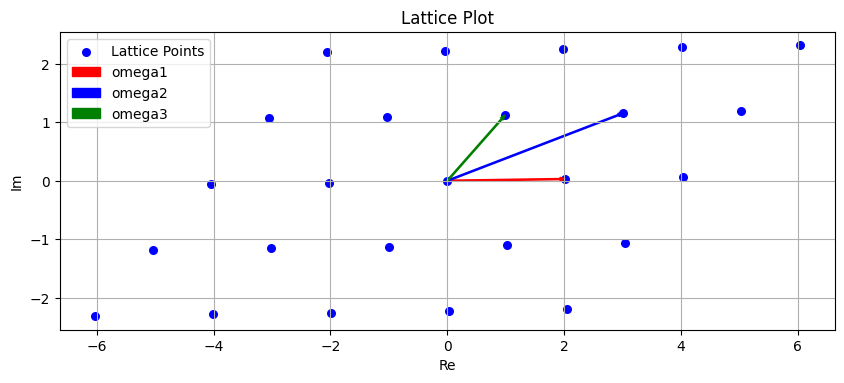

In [5]:

# g2val_ = 2.234
# g3val_ = 3.245
g2val_ = -2.234+0.13j
g3val_ = 0.245-0.0234j
omega_ = we.omega_from_g(g2val_, g3val_)
omega1_ = mpc_to_float(omega_[0])
omega2_ = mpc_to_float(omega_[1])
omega3_ = mpc_to_float(omega_[2])
if im(omega2_/omega1_) <= 0:
    omega1_ = -omega2_
    
omega1_ = omega1_ - 2*omega2_
omega2_ = omega2_ + 2*omega1_
# omega3_ = omega3_ - 2*omega2_

omegas = (omega1_, omega2_)

zVal_ = 0.234
xVal_ = 1.234 + 0.245j

tau_ = we.tau_from_g(g2val_, g3val_)

omega1_
omega2_
omega3_
tau_
omega2_/omega1_
omega3_/omega1_
omega2_/omega3_

weierstrass_num_subs = [
    (omega1, omega1_), (omega2, omega2_), (omega3, omega3_), (g2, g2val_), (g3, g3val_), (z, zVal_), (x, xVal_)
]

# This should show the fundamental lattice cell
plot_lattice(omega1_, omega2_, omega3_, n_points=2)

## The known relationship between Carlson RF and Weierstrass elliptic functions

https://dlmf.nist.gov/19.25#E35

For some integers $k, l, m$:

In [6]:
rf_carlson_weierstrass = Eq(z + 2*k*omega1 + 2*l*omega3, 
   (-1)**m*RF(pw(z,g2,g3) - pw(omega1,g2,g3), pw(z,g2,g3) - pw(omega2,g2,g3), pw(z,g2,g3) - pw(omega3,g2,g3))
)
rf_klm_integers = [(k,0),(l,0),(m,2)]

num_evaluate_weierstrass_carlson(rf_carlson_weierstrass, weierstrass_num_subs + rf_klm_integers)

LHS 0.234000000000000
RHS (0.23399999999999993-6.883535868968061e-18j)
ERROR (SMAPE) 3.57054564932798e-16


Eq(2*k*omega1 + 2*l*omega3 + z, (-1)**m*RF(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3)))

## The known relationship between Carlson RG and Weierstrass elliptic functions

https://dlmf.nist.gov/19.25#E37

For some integers $k, l, m$:

In [7]:
rg_carlson_weierstrass = Eq(
    zw(z + 2*k*omega1 + 2*l*omega3, g2,g3) + (z + 2*k*omega1 + 2*l*omega3)*pw(z,g2,g3), 
   (-1)**m*2*RG(pw(z,g2,g3) - pw(omega1,g2,g3), pw(z,g2,g3) - pw(omega2,g2,g3), pw(z,g2,g3) - pw(omega3,g2,g3))
)
rg_klm_integers = [(k,0),(l,0),(m,2)]

num_evaluate_weierstrass_carlson(rg_carlson_weierstrass, weierstrass_num_subs + rg_klm_integers)

LHS 8.5460594598208 + 5.50376649799781e-5*I
RHS 8.5460594598208 + 5.50376649798641e-5*I
ERROR (SMAPE) 1.33407256565537e-17


Eq((2*k*omega1 + 2*l*omega3 + z)*pw(z, g2, g3) + zw(2*k*omega1 + 2*l*omega3 + z, g2, g3), 2*(-1)**m*RG(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3)))

## The new relationship between Carlson RJ and Weierstrass elliptic functions
This does not seemingly appear anywhere in the literature and is presumed to be new. In what follows I'm playing fast and loose with re integration paths in the complex domain. *Waves hands like a Physicist* 

In [8]:

df_hyp_b = Eq(Derivative(f(z,x), z)**2, (f(z,x) - pw(x, g2, g3))**2*(-g2*f(z,x) - g3 + 4*f(z,x)**3))

fh_rho_sub = Eq(f(z,x),h(rho(z,x)))
dh_rhoz = df_hyp_b.subs(*fh_rho_sub.args).doit()
d_rhoz_h = Eq(diff(rho(z,x),z), (h(rho(z,x)) - pw(x,g2,g3)))
dh_rhoz_b = dh_rhoz.subs(*d_rhoz_h.args)

dh_rhoz_c = Eq(
    dh_rhoz_b.lhs/(dh_rhoz_b.lhs.subs(diff(h(rho(z,x)),rho(z,x)),1)), 
    dh_rhoz_b.rhs/(dh_rhoz_b.lhs.subs(diff(h(rho(z,x)),rho(z,x)),1))
).subs(rho(z,x), t).simplify()
h_pw = Eq(h(t), pw(t-t0,g2,g3))
fp_rho_sub = Eq(f(z,x),pw(rho(z,x)-t0,g2,g3))


integral_rhoz_t_a = Eq(Integral(1/(pw(t-t0,g2,g3) - pw(x,g2,g3)),(t,rho(z0,x), rho(z,x))), Integral(1,(z,z0,z)))
integral_rhoz_t_b = Eq(Integral(pwp(x,g2,g3)/(-pw(y,g2,g3) + pw(x,g2,g3)),(y,rho(z0,x) - t0, rho(z,x) - t0)), 
                     pwp(x,g2,g3)*Integral(1,(z,z0,z)).doit())
integral_rhoz_t_c = Eq(
    Integral(
        (pwp(x,g2,g3)/(-pw(y,g2,g3) + pw(x,g2,g3))).subs(*pwp_x_y_log_sigma_diff_c.args),
        (y,rho(z0,x) - t0, rho(z,x) - t0)
    ), 
    pwp(x,g2,g3)*Integral(1,(z,z0,z)).doit()
)

integral_rhoz_t_d = Eq(
    log_sigma_xy_phase.subs(y, rho(z,x) - t0) - log_sigma_xy_phase.subs(y, rho(z0,x) - t0),
    integral_rhoz_t_c.rhs
)

r_rho_zx = Eq(rho(z,x), r(z,x) + t0)
integral_r_zx = integral_rhoz_t_d.subs([r_rho_zx.args, r_rho_zx.subs(z,z0).args])


fr_sub = fp_rho_sub.subs(*r_rho_zx.args)

d_r_h_zx = d_rhoz_h.subs(*h_pw.subs(t,rho(z,x)).args).subs(*r_rho_zx.args).doit()

df_hyp_b
fh_rho_sub
dh_rhoz
d_rhoz_h
dh_rhoz_c
h_pw
fp_rho_sub


integral_rhoz_t_a
integral_rhoz_t_b
pwp_x_y_log_sigma_diff_c
integral_rhoz_t_c
integral_rhoz_t_d
r_rho_zx

fr_sub
integral_r_zx
d_r_h_zx

Eq(Derivative(f(z, x), z)**2, (f(z, x) - pw(x, g2, g3))**2*(-g2*f(z, x) - g3 + 4*f(z, x)**3))

Eq(f(z, x), h(rho(z, x)))

Eq(Derivative(h(rho(z, x)), rho(z, x))**2*Derivative(rho(z, x), z)**2, (h(rho(z, x)) - pw(x, g2, g3))**2*(-g2*h(rho(z, x)) - g3 + 4*h(rho(z, x))**3))

Eq(Derivative(rho(z, x), z), h(rho(z, x)) - pw(x, g2, g3))

Eq(Derivative(h(t), t)**2, -g2*h(t) - g3 + 4*h(t)**3)

Eq(h(t), pw(t - t0, g2, g3))

Eq(f(z, x), pw(-t0 + rho(z, x), g2, g3))

Eq(Integral(1/(-pw(x, g2, g3) + pw(t - t0, g2, g3)), (t, rho(z0, x), rho(z, x))), Integral(1, (z, z0, z)))

Eq(Integral(pwp(x, g2, g3)/(pw(x, g2, g3) - pw(y, g2, g3)), (y, -t0 + rho(z0, x), -t0 + rho(z, x))), (z - z0)*pwp(x, g2, g3))

Eq(pwp(x, g2, g3)/(pw(x, g2, g3) - pw(y, g2, g3)), Derivative(log(sigma(x + y, g2, g3)*exp(-2*y*zw(x, g2, g3))/sigma(-x + y, g2, g3)), y))

Eq(Integral(Derivative(log(sigma(x + y, g2, g3)*exp(-2*y*zw(x, g2, g3))/sigma(-x + y, g2, g3)), y), (y, -t0 + rho(z0, x), -t0 + rho(z, x))), (z - z0)*pwp(x, g2, g3))

Eq(log(sigma(-t0 + x + rho(z, x), g2, g3)*exp(-2*(-t0 + rho(z, x))*zw(x, g2, g3))/sigma(-t0 - x + rho(z, x), g2, g3)) - log(sigma(-t0 + x + rho(z0, x), g2, g3)*exp(-2*(-t0 + rho(z0, x))*zw(x, g2, g3))/sigma(-t0 - x + rho(z0, x), g2, g3)), (z - z0)*pwp(x, g2, g3))

Eq(rho(z, x), t0 + r(z, x))

Eq(f(z, x), pw(r(z, x), g2, g3))

Eq(log(sigma(x + r(z, x), g2, g3)*exp(-2*r(z, x)*zw(x, g2, g3))/sigma(-x + r(z, x), g2, g3)) - log(sigma(x + r(z0, x), g2, g3)*exp(-2*r(z0, x)*zw(x, g2, g3))/sigma(-x + r(z0, x), g2, g3)), (z - z0)*pwp(x, g2, g3))

Eq(Derivative(r(z, x), z), -pw(x, g2, g3) + pw(r(z, x), g2, g3))

To simplify notation in what follows, let us write $s(z)$ to mean $s(z,\mu_1, \mu_2, \mu_3, p)$, and $c$ to mean $c(\mu_1, \mu_2, \mu_3,p)$.

In [9]:
# https://dlmf.nist.gov/19.16
Rj_carlson = Eq(RJ(x,y,z,p), Rational(3,2)*Integral(1/(t+p)/sqrt((t+x)*(t+y)*(t+z)),(t,0,oo)))
Rj_carlson_b = Eq(RJ(x,y,z,p), Rational(3,2)*Integral(
    1/(t+p - epsilon)/sqrt((t+x - epsilon)*(t+y - epsilon)*(t+z - epsilon)),(t,epsilon,oo)))
Rj_carlson_c = (Rj_carlson_b
                .subs([(x,x+epsilon),(y,y+epsilon),(z,z+epsilon),(p,p+epsilon)])
                .subs([(x,mu[1]),(y,mu[2]),(z,mu[3])])
                .subs([(epsilon,s(z))])
               )

Rj_carlson
Rj_carlson_b
Rj_carlson_c

Eq(RJ(x, y, z, p), 3*Integral(1/(sqrt((t + x)*(t + y)*(t + z))*(t + p)), (t, 0, oo))/2)

Eq(RJ(x, y, z, p), 3*Integral(1/(sqrt((t + x - epsilon)*(t + y - epsilon)*(t + z - epsilon))*(t - epsilon + p)), (t, epsilon, oo))/2)

Eq(RJ(s(z) + mu[1], s(z) + mu[2], s(z) + mu[3], s(z) + p), 3*Integral(1/(sqrt((t + mu[1])*(t + mu[2])*(t + mu[3]))*(t + p)), (t, s(z), oo))/2)

Let us assume a function $s(z)$ exists such that it inverts $R_j$ as follows:

In [10]:
Rj_carlson_c_z = Eq(Rj_carlson_c.lhs, z + c)
Rj_carlson_d_z = Rj_carlson_c.subs(*Rj_carlson_c_z.args)

Rj_carlson_c_z
Rj_carlson_d_z

Eq(RJ(s(z) + mu[1], s(z) + mu[2], s(z) + mu[3], s(z) + p), z + c)

Eq(z + c, 3*Integral(1/(sqrt((t + mu[1])*(t + mu[2])*(t + mu[3]))*(t + p)), (t, s(z), oo))/2)

Then it follows that:

In [11]:
Rj_carlson_d_z_diff = Eq(diff(Rj_carlson_d_z.lhs,z), diff(Rj_carlson_d_z.rhs,z))
Rj_carlson_d_z_diff_b = Eq(diff(s(z),z)**2, 
                           solve(Eq(Rj_carlson_d_z_diff.lhs**2, Rj_carlson_d_z_diff.rhs**2),
                                 diff(s(z,),z)**2)[0].factor()
                          )

sz_chi_sub = Eq(s(z),h(chi(z)))
chi_s = Rj_carlson_d_z_diff_b.subs(*sz_chi_sub.args).doit()
dsz_chi_sub = Eq(diff(chi(z),z), (h(chi(z)) + p)/3)
h_chi_z = Eq(h(t), pw(t,g2,g3))
mu_omega1 = Eq(mu[1], -pw(omega1,g2,g3))
mu_omega2 = Eq(mu[2], -pw(omega2,g2,g3))
mu_omega3 = Eq(mu[3], -pw(omega3,g2,g3))
p_pw_x = Eq(p, -pw(x,g2,g3))

carlson_chi_inv = Rj_carlson_c_z.subs([
    (s(z),pw(chi(z),g2,g3)), mu_omega1.args, mu_omega2.args, mu_omega3.args, p_pw_x.args])

zZ3 = Eq(z, Z*3)
dh_chi_sub_Z = Eq(Derivative(chi(Z*3),Z), (pw(chi(Z*3),g2,g3) - pw(x,g2,g3)))


Rj_carlson_d_z_diff
Rj_carlson_d_z_diff_b

sz_chi_sub
chi_s
dsz_chi_sub
h_chi_z
mu_omega1
mu_omega2
mu_omega3
p_pw_x
carlson_chi_inv

zZ3
dh_chi_sub_Z

Eq(1, -3*Derivative(s(z), z)/(2*sqrt((s(z) + mu[1])*(s(z) + mu[2])*(s(z) + mu[3]))*(s(z) + p)))

Eq(Derivative(s(z), z)**2, 4*(s(z) + mu[1])*(s(z) + mu[2])*(s(z) + mu[3])*(s(z) + p)**2/9)

Eq(s(z), h(chi(z)))

Eq(Derivative(chi(z), z)**2*Derivative(h(chi(z)), chi(z))**2, 4*(h(chi(z)) + mu[1])*(h(chi(z)) + mu[2])*(h(chi(z)) + mu[3])*(h(chi(z)) + p)**2/9)

Eq(Derivative(chi(z), z), h(chi(z))/3 + p/3)

Eq(h(t), pw(t, g2, g3))

Eq(mu[1], -pw(omega1, g2, g3))

Eq(mu[2], -pw(omega2, g2, g3))

Eq(mu[3], -pw(omega3, g2, g3))

Eq(p, -pw(x, g2, g3))

Eq(RJ(-pw(omega1, g2, g3) + pw(chi(z), g2, g3), -pw(omega2, g2, g3) + pw(chi(z), g2, g3), -pw(omega3, g2, g3) + pw(chi(z), g2, g3), -pw(x, g2, g3) + pw(chi(z), g2, g3)), z + c)

Eq(z, 3*Z)

Eq(Derivative(chi(3*Z), Z), -pw(x, g2, g3) + pw(chi(3*Z), g2, g3))

Assuming that the solution to the associated differential equation is unique, then:

In [12]:
chi_r_3z = Eq(chi(3*z), r(z,x))
carlson_rxz_inv = carlson_chi_inv.subs(z,z*3).subs(*chi_r_3z.args)
carlson_rxz_inv = Eq(pwp(x,g2,g3)*(carlson_rxz_inv.lhs - c), 3*pwp(x,g2,g3)*(carlson_rxz_inv.rhs - c)/3).expand()
integral_r_zx_b = Eq(3*(integral_r_zx.rhs + z0*pwp(x,g2,g3)).simplify(), 3*integral_r_zx.lhs + z0*pwp(x,g2,g3) )

carlson_phase_inv_rzx = carlson_rxz_inv.subs(*integral_r_zx_b.args)
carlson_phase_inv_z = carlson_phase_inv_rzx.subs(r(z,x),z)
carlson_phase_inv_z = Eq(carlson_phase_inv_z.lhs + pwp(x,g2,g3)*c, carlson_phase_inv_z.rhs + pwp(x,g2,g3)*c)

RJ_p_lim_oo = Eq(Limit(RJ(x,y,z,p),p,oo),0)
RJ_pw_z_lim_0 = Eq(Limit(carlson_phase_inv_z.lhs,z,0),0)
RJ_lim_lhs_rhs = Eq(Limit(carlson_phase_inv_z.lhs,z,0), Limit(carlson_phase_inv_z.rhs,z,0))
RJ_lim_taken_z_0 =RJ_lim_lhs_rhs.subs(*RJ_pw_z_lim_0.args).doit().subs(sigma(-x,g2,g3), -sigma(x,g2,g3))
RJ_carlson_pw_3ipi = Eq(carlson_phase_inv_z.lhs - RJ_lim_taken_z_0.lhs, 
                        carlson_phase_inv_z.rhs - RJ_lim_taken_z_0.rhs)


chi_r_3z
carlson_rxz_inv
integral_r_zx_b
carlson_phase_inv_rzx
carlson_phase_inv_z

RJ_p_lim_oo
RJ_pw_z_lim_0
RJ_lim_lhs_rhs
RJ_lim_taken_z_0
RJ_carlson_pw_3ipi

Eq(chi(3*z), r(z, x))

Eq(RJ(-pw(omega1, g2, g3) + pw(r(z, x), g2, g3), -pw(omega2, g2, g3) + pw(r(z, x), g2, g3), -pw(omega3, g2, g3) + pw(r(z, x), g2, g3), -pw(x, g2, g3) + pw(r(z, x), g2, g3))*pwp(x, g2, g3) - pwp(x, g2, g3)*c, 3*z*pwp(x, g2, g3))

Eq(3*z*pwp(x, g2, g3), z0*pwp(x, g2, g3) + 3*log(sigma(x + r(z, x), g2, g3)*exp(-2*r(z, x)*zw(x, g2, g3))/sigma(-x + r(z, x), g2, g3)) - 3*log(sigma(x + r(z0, x), g2, g3)*exp(-2*r(z0, x)*zw(x, g2, g3))/sigma(-x + r(z0, x), g2, g3)))

Eq(RJ(-pw(omega1, g2, g3) + pw(r(z, x), g2, g3), -pw(omega2, g2, g3) + pw(r(z, x), g2, g3), -pw(omega3, g2, g3) + pw(r(z, x), g2, g3), -pw(x, g2, g3) + pw(r(z, x), g2, g3))*pwp(x, g2, g3) - pwp(x, g2, g3)*c, z0*pwp(x, g2, g3) + 3*log(sigma(x + r(z, x), g2, g3)*exp(-2*r(z, x)*zw(x, g2, g3))/sigma(-x + r(z, x), g2, g3)) - 3*log(sigma(x + r(z0, x), g2, g3)*exp(-2*r(z0, x)*zw(x, g2, g3))/sigma(-x + r(z0, x), g2, g3)))

Eq(RJ(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3), -pw(x, g2, g3) + pw(z, g2, g3))*pwp(x, g2, g3), z0*pwp(x, g2, g3) + pwp(x, g2, g3)*c + 3*log(sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(-x + z, g2, g3)) - 3*log(sigma(x + r(z0, x), g2, g3)*exp(-2*r(z0, x)*zw(x, g2, g3))/sigma(-x + r(z0, x), g2, g3)))

Eq(Limit(RJ(x, y, z, p), p, oo, dir='-'), 0)

Eq(Limit(RJ(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3), -pw(x, g2, g3) + pw(z, g2, g3))*pwp(x, g2, g3), z, 0, dir='+'), 0)

Eq(Limit(RJ(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3), -pw(x, g2, g3) + pw(z, g2, g3))*pwp(x, g2, g3), z, 0, dir='+'), Limit(z0*pwp(x, g2, g3) + pwp(x, g2, g3)*c + 3*log(sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(-x + z, g2, g3)) - 3*log(sigma(x + r(z0, x), g2, g3)*exp(-2*r(z0, x)*zw(x, g2, g3))/sigma(-x + r(z0, x), g2, g3)), z, 0, dir='+'))

Eq(0, z0*pwp(x, g2, g3) + pwp(x, g2, g3)*c - 3*log(sigma(x + r(z0, x), g2, g3)*exp(-2*r(z0, x)*zw(x, g2, g3))/sigma(-x + r(z0, x), g2, g3)) + 3*I*pi)

Eq(RJ(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3), -pw(x, g2, g3) + pw(z, g2, g3))*pwp(x, g2, g3), 3*log(sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(-x + z, g2, g3)) - 3*I*pi)

Which thus gives the missing relation between Carlson's $R_j$ function and the Weierstrass elliptic functions as:

In [13]:
rj_carlson_weierstrass = Eq(
    RJ(
        -pw(omega1, g2, g3) + pw(z, g2, g3), 
        -pw(omega2, g2, g3) + pw(z, g2, g3), 
        -pw(omega3, g2, g3) + pw(z, g2, g3), 
        -pw(x, g2, g3) + pw(z, g2, g3)
    ),
 (-1)**m*3*log(sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(x - z, g2, g3))/pwp(x, g2, g3)
)
rj_klm_integers = [(k,0),(l,0),(m,1)]

num_evaluate_weierstrass_carlson(rj_carlson_weierstrass, weierstrass_num_subs + rj_klm_integers)

LHS (0.013002608500384687-0.00011921654079634512j)
RHS 0.0130026085003835 - 0.000119216540797231*I
ERROR (SMAPE) 1.12405564479905e-13


Eq(RJ(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3), -pw(x, g2, g3) + pw(z, g2, g3)), 3*(-1)**m*log(sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(x - z, g2, g3))/pwp(x, g2, g3))

### Simpler proof

In [16]:
rj_carl_weier_intgr = Rj_carlson.subs([
    (z,pw(z,g2,g3) - pw(omega3,g2,g3)), (y,pw(z,g2,g3) - pw(omega2,g2,g3)), 
    (x,pw(z,g2,g3) - pw(omega1,g2,g3)), (p,pw(z,g2,g3) - pw(x,g2,g3)), 
])

rj_carl_weier_intgr_vch = Eq(rj_carl_weier_intgr.rhs, 3*Integral(
    1/(sqrt(
        (t - pw(omega1, g2, g3))*
        (t - pw(omega2, g2, g3))*
        (t - pw(omega3, g2, g3))
    )*(t - pw(x, g2, g3))), (t, pw(z, g2, g3), oo))/2
)
rj_carl_weier_intgr_b = rj_carl_weier_intgr.subs(*rj_carl_weier_intgr_vch.args)

rj_carl_weier_intgr_dz = Eq(Derivative(rj_carl_weier_intgr_b.lhs,z), diff(rj_carl_weier_intgr_b.rhs,z))

wp_prime_def = Eq(Derivative(pw(z, g2, g3), z), 
   (-1)**m*2*sqrt(
       (-pw(omega1, g2, g3) + pw(z, g2, g3))*
       (-pw(omega2, g2, g3) + pw(z, g2, g3))*
       (-pw(omega3, g2, g3) + pw(z, g2, g3))
   )
)

rj_carl_weier_intgr_dz_b = rj_carl_weier_intgr_dz.subs(*wp_prime_def.args)
rj_carl_weier_intgr_dz_c = Eq(rj_carl_weier_intgr_dz_b.lhs, 
    (rj_carl_weier_intgr_dz_b.rhs
    -3*(-1)**m*(
        pwp_x_y_log_sigma_diff_c.lhs.subs(y,z)/pwp(x,g2,g3) - 
        pwp_x_y_log_sigma_diff_c.rhs.subs(y,z)/pwp(x,g2,g3)
    )).expand().collect(1/pwp(x,g2,g3),factor)
)

log_sigma_x_neg_dz = Eq(
    Derivative(log(sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(-x + z, g2, g3)),z), 
    Derivative(log(sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(x - z, g2, g3)),z)
)
rj_carl_weier_intgr_dz_d = rj_carl_weier_intgr_dz_c.subs(*log_sigma_x_neg_dz.args)
rj_carl_weier_intgr_dz_d = Eq(
    Integral(rj_carl_weier_intgr_dz_d.lhs,(z,0,z)), Integral(rj_carl_weier_intgr_dz_d.rhs,(z,0,z))
)
rj_carlson_weierstrass_simpler = Eq(RJ(
    -pw(omega1, g2, g3) + pw(z, g2, g3), 
    -pw(omega2, g2, g3) + pw(z, g2, g3), 
    -pw(omega3, g2, g3) + pw(z, g2, g3), 
    -pw(x, g2, g3) + pw(z, g2, g3)),
    3*(-1)**m*log(sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(x - z, g2, g3))/pwp(x, g2, g3)
)


rj_carl_weier_intgr
rj_carl_weier_intgr_b
rj_carl_weier_intgr_dz
rj_carl_weier_intgr_dz_b
rj_carl_weier_intgr_dz_c
log_sigma_x_neg_dz
rj_carl_weier_intgr_dz_d


num_evaluate_weierstrass_carlson(rj_carlson_weierstrass_simpler, weierstrass_num_subs + [(m,1)])

Eq(RJ(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3), -pw(x, g2, g3) + pw(z, g2, g3)), 3*Integral(1/(sqrt((t - pw(omega1, g2, g3) + pw(z, g2, g3))*(t - pw(omega2, g2, g3) + pw(z, g2, g3))*(t - pw(omega3, g2, g3) + pw(z, g2, g3)))*(t - pw(x, g2, g3) + pw(z, g2, g3))), (t, 0, oo))/2)

Eq(RJ(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3), -pw(x, g2, g3) + pw(z, g2, g3)), 3*Integral(1/(sqrt((t - pw(omega1, g2, g3))*(t - pw(omega2, g2, g3))*(t - pw(omega3, g2, g3)))*(t - pw(x, g2, g3))), (t, pw(z, g2, g3), oo))/2)

Eq(Derivative(RJ(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3), -pw(x, g2, g3) + pw(z, g2, g3)), z), -3*Derivative(pw(z, g2, g3), z)/(2*sqrt((-pw(omega1, g2, g3) + pw(z, g2, g3))*(-pw(omega2, g2, g3) + pw(z, g2, g3))*(-pw(omega3, g2, g3) + pw(z, g2, g3)))*(-pw(x, g2, g3) + pw(z, g2, g3))))

Eq(Derivative(RJ(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3), -pw(x, g2, g3) + pw(z, g2, g3)), z), -3*(-1)**m/(-pw(x, g2, g3) + pw(z, g2, g3)))

Eq(Derivative(RJ(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3), -pw(x, g2, g3) + pw(z, g2, g3)), z), 3*(-1)**m*Derivative(log(sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(-x + z, g2, g3)), z)/pwp(x, g2, g3))

Eq(Derivative(log(sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(-x + z, g2, g3)), z), Derivative(log(sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(x - z, g2, g3)), z))

Eq(Integral(Derivative(RJ(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3), -pw(x, g2, g3) + pw(z, g2, g3)), z), (z, 0, z)), Integral(3*(-1)**m*Derivative(log(sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(x - z, g2, g3)), z)/pwp(x, g2, g3), (z, 0, z)))

LHS (0.013002608500384687-0.00011921654079634512j)
RHS 0.0130026085003835 - 0.000119216540797231*I
ERROR (SMAPE) 1.12405564479905e-13


Eq(RJ(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3), -pw(x, g2, g3) + pw(z, g2, g3)), 3*(-1)**m*log(sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(x - z, g2, g3))/pwp(x, g2, g3))

### Relation for swapping z and x
This also does not seemingly appear anywhere in the literature and is presumed to be new. However, this shows the problem with playing fast and loose with the integration path. It seems that at least one of the $Rj$ terms is undefined depending on which way round we have $x$ and $z$. This relation therfore, may be useful for redefining the problematic case in terms of the other one.

In [17]:
rj_carlson_weierstrass_z_swap_x_a = Eq(
    rj_carlson_weierstrass.lhs*pwp(x,g2,g3) - 
    (rj_carlson_weierstrass.lhs*pwp(x,g2,g3)).subs([(x,y),(z,x)]).subs(y,z),
    rj_carlson_weierstrass.rhs*pwp(x,g2,g3) - 
    (rj_carlson_weierstrass.rhs*pwp(x,g2,g3)).subs([(x,y),(z,x)]).subs(y,z)
)

log_zx_sub1 = Eq(log(sigma(x + z, g2, g3)*exp(-2*x*zw(z, g2, g3))/sigma(-x + z, g2, g3)),
   log(sigma(x + z, g2, g3)/sigma(x - z, g2, g3)) - 2*x*zw(z, g2, g3) + log(-1)
  )
log_zx_sub2 = Eq(log(sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(x - z, g2, g3)),
   log(sigma(x + z, g2, g3)/sigma(x - z, g2, g3)) - 2*z*zw(x, g2, g3)
  )
rj_carlson_weierstrass_z_swap_x_b = Eq(rj_carlson_weierstrass_z_swap_x_a.lhs, 
    rj_carlson_weierstrass_z_swap_x_a.rhs.subs([log_zx_sub1.args, log_zx_sub2.args]).expand().factor()
)

rj_carlson_weierstrass_z_swap_x_a
rj_carlson_weierstrass_z_swap_x_b

Eq(-RJ(-pw(omega1, g2, g3) + pw(x, g2, g3), -pw(omega2, g2, g3) + pw(x, g2, g3), -pw(omega3, g2, g3) + pw(x, g2, g3), pw(x, g2, g3) - pw(z, g2, g3))*pwp(z, g2, g3) + RJ(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3), -pw(x, g2, g3) + pw(z, g2, g3))*pwp(x, g2, g3), -3*(-1)**m*log(sigma(x + z, g2, g3)*exp(-2*x*zw(z, g2, g3))/sigma(-x + z, g2, g3)) + 3*(-1)**m*log(sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(x - z, g2, g3)))

Eq(-RJ(-pw(omega1, g2, g3) + pw(x, g2, g3), -pw(omega2, g2, g3) + pw(x, g2, g3), -pw(omega3, g2, g3) + pw(x, g2, g3), pw(x, g2, g3) - pw(z, g2, g3))*pwp(z, g2, g3) + RJ(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3), -pw(x, g2, g3) + pw(z, g2, g3))*pwp(x, g2, g3), 3*(-1)**m*(2*x*zw(z, g2, g3) - 2*z*zw(x, g2, g3) - I*pi))

In [18]:
num_evaluate_weierstrass_carlson(rj_carlson_weierstrass_z_swap_x_b, weierstrass_num_subs + [(m,1)])

LHS nan
RHS -30.466265716445 + 2.96803088494047*I
ERROR (SMAPE) nan


Eq(-RJ(-pw(omega1, g2, g3) + pw(x, g2, g3), -pw(omega2, g2, g3) + pw(x, g2, g3), -pw(omega3, g2, g3) + pw(x, g2, g3), pw(x, g2, g3) - pw(z, g2, g3))*pwp(z, g2, g3) + RJ(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3), -pw(x, g2, g3) + pw(z, g2, g3))*pwp(x, g2, g3), 3*(-1)**m*(2*x*zw(z, g2, g3) - 2*z*zw(x, g2, g3) - I*pi))

## Relating $r(z,x)$ to properties of Kronecker theta functions and Weierstrass elliptic functions

We denote the Kronecker theta function $\kappa(z,x)$.

### Properties of the Kronecker theta phase $\phi(z,x)$

In [61]:
kron_theta = Eq(kappa(z,x), sigma(z+x,g2,g3)/sigma(x,g2,g3)/sigma(z,g2,g3)*exp(-z*zw(x,g2,g3)))
kron_theta_conj = kron_theta.subs(z,-z).subs([
       (zw(-z,g2,g3),-zw(z,g2,g3)),(sigma(-z,g2,g3), -sigma(z,g2,g3)), (sigma(x-z,g2,g3), -sigma(z-x,g2,g3))
   ])
sigma_p_identity_zx = sigma_p_identity.subs([(x,z),(y,x)])
kron_pw = Eq(kron_theta.lhs*kron_theta_conj.lhs, 
   (kron_theta.rhs*kron_theta_conj.rhs).subs(sigma_p_identity_zx.rhs, sigma_p_identity_zx.lhs)
  )
kron_phase_a = Eq(kron_theta.lhs/kron_theta_conj.lhs, kron_theta.rhs/kron_theta_conj.rhs)
kron_phase_b = Eq(kron_phase_a.lhs, exp(2*phi(z)))
phase_odd = Eq(phi(-z), -phi(z))
phi_log_sigma = Eq(phi(z), log(kron_phase_b.lhs.subs(*kron_phase_a.args))/2)

kron_theta
kron_theta_conj
sigma_p_identity_zx
kron_pw
kron_phase_a
kron_phase_b
phase_odd
phi_log_sigma

Eq(kappa(z, x), sigma(x + z, g2, g3)*exp(-z*zw(x, g2, g3))/(sigma(x, g2, g3)*sigma(z, g2, g3)))

Eq(kappa(-z, x), sigma(-x + z, g2, g3)*exp(z*zw(x, g2, g3))/(sigma(x, g2, g3)*sigma(z, g2, g3)))

Eq(pw(x, g2, g3) - pw(z, g2, g3), sigma(-x + z, g2, g3)*sigma(x + z, g2, g3)/(sigma(x, g2, g3)**2*sigma(z, g2, g3)**2))

Eq(kappa(-z, x)*kappa(z, x), pw(x, g2, g3) - pw(z, g2, g3))

Eq(kappa(z, x)/kappa(-z, x), sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(-x + z, g2, g3))

Eq(kappa(z, x)/kappa(-z, x), exp(2*phi(z)))

Eq(phi(-z), -phi(z))

Eq(phi(z), log(sigma(x + z, g2, g3)*exp(-2*z*zw(x, g2, g3))/sigma(-x + z, g2, g3))/2)

### Properties of the Kronecker theta phase inverse $r(z,x)$

The following properties are implied for $r(z,x)$. However, there may be a mistake somewhere because if the ratio to the conjugate is an exponential, then for some values of $x$ the Frobenius-Stickelberger determinant would imply the Kronecker theta function is an algebraic function of $e^z$ which sounds wrong.

In [82]:
phi_rxz = integral_r_zx.subs([
    (2*phi_log_sigma.subs(z,r(z,x)).rhs, 2*phi_log_sigma.subs(z,r(z,x)).lhs),
    (2*phi_log_sigma.subs(z,r(z0,x)).rhs, 2*phi_log_sigma.subs(z,r(z0,x)).lhs)
])
kron_ratio_phase_inv = kron_phase_b.subs(z,r(z,x)).subs(phi(r(z,x)), solve(phi_rxz, phi(r(z,x)))[0])
kappa_sqrd_periodic = Eq(
    kron_pw.lhs.subs(z,r(z,x))*kron_ratio_phase_inv.lhs/kron_ratio_phase_inv.rhs, 
    kron_pw.rhs.subs(z,r(z,x))
)


phi_rxz
kron_ratio_phase_inv
kappa_sqrd_periodic

Eq(2*phi(r(z, x)) - 2*phi(r(z0, x)), (z - z0)*pwp(x, g2, g3))

Eq(kappa(r(z, x), x)/kappa(-r(z, x), x), exp(z*pwp(x, g2, g3) - z0*pwp(x, g2, g3) + 2*phi(r(z0, x))))

Eq(kappa(r(z, x), x)**2*exp(-z*pwp(x, g2, g3) + z0*pwp(x, g2, g3) - 2*phi(r(z0, x))), pw(x, g2, g3) - pw(r(z, x), g2, g3))

In [100]:
rj_carlson_weierstrass_phi = rj_carlson_weierstrass.subs(
    phi_log_sigma.rhs.subs(sigma(z-x,g2,g3), sigma(x-z,g2,g3))*2, 
    phi_log_sigma.lhs*2 - log(-1)
)
rj_carlson_weierstrass_phi = Eq(
    rj_carlson_weierstrass_phi.rhs*pwp(x,g2,g3)/6/(-1)**m + I*pi/2,
    rj_carlson_weierstrass_phi.lhs*pwp(x,g2,g3)/6*(-1)**m + I*pi/2
)
rj_carlson_weierstrass_phi

Eq(phi(z), (-1)**m*RJ(-pw(omega1, g2, g3) + pw(z, g2, g3), -pw(omega2, g2, g3) + pw(z, g2, g3), -pw(omega3, g2, g3) + pw(z, g2, g3), -pw(x, g2, g3) + pw(z, g2, g3))*pwp(x, g2, g3)/6 + I*pi/2)

## Reminder of connection between $r(z,x)$ and $f(z,x)$

In [289]:
drzx_2 = Eq(diff(d_r_h_zx.lhs,z), diff(d_r_h_zx.rhs,z).subs(*wpk(1).subs(z,r(z,x)).args))
frzx = Eq(f(z,x) - pw(x,g2,g3), diff(r(z,x),z))
dfrzx = drzx_2.subs(frzx.rhs, frzx.lhs).doit()
dfz_sqrd = Eq(dfrzx.lhs**2, 
   (dfrzx.rhs**2)
   .subs(*pwp_sqrd.subs(z,r(z,x)).args)
   .subs(pw(r(z,x),g2,g3), solve(d_r_h_zx, pw(r(z,x),g2,g3))[0])
   .subs(frzx.rhs, frzx.lhs)
  )

frzx
dfrzx
dfz_sqrd

Eq(f(z, x) - pw(x, g2, g3), Derivative(r(z, x), z))

Eq(Derivative(f(z, x), z), (f(z, x) - pw(x, g2, g3))*pwp(r(z, x), g2, g3))

Eq(Derivative(f(z, x), z)**2, (f(z, x) - pw(x, g2, g3))**2*(-g2*f(z, x) - g3 + 4*f(z, x)**3))

## Taylor series expansion of $s(z,x)$

In [290]:
szx = Eq(log(sigma(x + s(z, x), g2, g3)*exp(-2*s(z, x)*zw(x, g2, g3))/sigma(x - s(z, x), g2, g3)),z*pwp(x,g2,g3))
szx

Eq(log(sigma(x + s(z, x), g2, g3)*exp(-2*s(z, x)*zw(x, g2, g3))/sigma(x - s(z, x), g2, g3)), z*pwp(x, g2, g3))

In [291]:
pwp_log_xy_i_pi = pwp_x_y_log_sigma_diff_c.subs(sigma(-x+y,g2,g3), sigma(x-y,g2,g3))
pwp_log_xy_i_pi

Eq(pwp(x, g2, g3)/(pw(x, g2, g3) - pw(y, g2, g3)), Derivative(log(sigma(x + y, g2, g3)*exp(-2*y*zw(x, g2, g3))/sigma(x - y, g2, g3)), y))

In [292]:
dszx_a = Eq(
    diff(f(s(z,x)).subs(f(s(z,x)),szx.rhs),z),
    diff(f(s(z,x)),z)
    .subs(f(s(z,x)),szx.lhs)
    .subs(pwp_log_xy_i_pi.subs(y,s(z,x)).rhs, pwp_log_xy_i_pi.subs(y,s(z,x)).lhs)
)
dszx_b = Eq(diff(s(z,x),z), solve(dszx_a, diff(s(z,x),z))[0])
dszx_a
dszx_b

Eq(pwp(x, g2, g3), pwp(x, g2, g3)*Derivative(s(z, x), z)/(pw(x, g2, g3) - pw(s(z, x), g2, g3)))

Eq(Derivative(s(z, x), z), pw(x, g2, g3) - pw(s(z, x), g2, g3))

In [221]:
sz1 = Eq(s(z1,x), omega1)
z1_a = szx.subs(z,z1).subs(sz1.lhs, sz1.rhs)
z1_b = z1_a.subs(*quasi_period.subs([(m,0),(n,1),(z,x-omega1)]).simplify().args).simplify()
z1_def = Eq(z1, (log(-1) + 2*eta1*x - 2*omega1*zw(x, g2, g3))/pwp(x, g2, g3))
sz1
z1_a
z1_b
z1_def
pw_to_zw_identity.subs(y,omega1).subs(pwp(omega1,g2,g3),0)

Eq(s(z1, x), omega1)

Eq(log(sigma(omega1 + x, g2, g3)*exp(-2*omega1*zw(x, g2, g3))/sigma(-omega1 + x, g2, g3)), z1*pwp(x, g2, g3))

Eq(z1*pwp(x, g2, g3), log(-exp(2*eta1*x - 2*omega1*zw(x, g2, g3))))

Eq(z1, (2*eta1*x - 2*omega1*zw(x, g2, g3) + I*pi)/pwp(x, g2, g3))

Eq(pwp(x, g2, g3)/(2*(-pw(omega1, g2, g3) + pw(x, g2, g3))), -zw(omega1, g2, g3) - zw(x, g2, g3) + zw(omega1 + x, g2, g3))

In [227]:
szx_taylor = Eq(s(z + z1,x),Sum(z**n*Subs(Derivative(s(z,x), (z, n)), z, z1)/factorial(n), (n, 0, N)))

taylor_series_b
szx_taylor

Eq(f(x + a), Sum(x**n*Subs(Derivative(f(x), (x, n)), x, a)/factorial(n), (n, 0, N)))

Eq(s(z + z1, x), Sum(z**n*Subs(Derivative(s(z, x), (z, n)), z, z1)/factorial(n), (n, 0, N)))

In [240]:
szx_taylor.subs(N,3).doit()

Eq(s(z + z1, x), z**3*Derivative(s(z1, x), (z1, 3))/6 + z**2*Derivative(s(z1, x), (z1, 2))/2 + z*Derivative(s(z1, x), z1) + s(z1, x))

In [265]:
dszx_1_z1 = Eq(dszx_b.lhs.subs(z,z1), dszx_b.rhs.subs(z,z1).subs(*sz1.args))
dszx_1_z1

Eq(Derivative(s(z1, x), z1), -pw(omega1, g2, g3) + pw(x, g2, g3))

In [266]:
dszx_2 = Eq(diff(dszx_b.lhs,z), diff(dszx_b.rhs,z).subs(*wpk(1).subs(z,s(z,x)).args))
dszx_2_b = Eq(dszx_2.lhs, dszx_2.rhs.subs(*dszx_b.args))
dszx_2_z1 = Eq(dszx_2_b.subs(z,z1).lhs, dszx_2_b.subs(z,z1).rhs.subs(*sz1.args).subs(pwp(omega1,g2,g3),0))

Eq(diff(dszx_b.lhs,z), diff(dszx_b.rhs,z))
dszx_2
dszx_2_b
dszx_2_z1

Eq(Derivative(s(z, x), (z, 2)), -Derivative(pw(s(z, x), g2, g3), s(z, x))*Derivative(s(z, x), z))

Eq(Derivative(s(z, x), (z, 2)), -pwp(s(z, x), g2, g3)*Derivative(s(z, x), z))

Eq(Derivative(s(z, x), (z, 2)), -(pw(x, g2, g3) - pw(s(z, x), g2, g3))*pwp(s(z, x), g2, g3))

Eq(Derivative(s(z1, x), (z1, 2)), 0)

In [267]:
dszx_3 = Eq(diff(dszx_b.lhs,z,2), 
            diff(dszx_b.rhs,z,2)
            .subs([
                wpk(2).subs(z,s(z,x)).args,
                wpk(1).subs(z,s(z,x)).args,
                dszx_2_b.args,
                dszx_b.args,
            ])
            .simplify()
           )
dszx_3_z1 = Eq(dszx_3.lhs.subs(z,z1), dszx_3.rhs.subs(z,z1).subs(*sz1.args).subs(pwp(omega1,g2,g3),0))

dszx_3
dszx_3_z1

Eq(Derivative(s(z, x), (z, 3)), ((g2 - 12*pw(s(z, x), g2, g3)**2)*(pw(x, g2, g3) - pw(s(z, x), g2, g3)) + 2*pwp(s(z, x), g2, g3)**2)*(pw(x, g2, g3) - pw(s(z, x), g2, g3))/2)

Eq(Derivative(s(z1, x), (z1, 3)), (g2 - 12*pw(omega1, g2, g3)**2)*(-pw(omega1, g2, g3) + pw(x, g2, g3))**2/2)

In [274]:
dszx_4 = Eq(diff(dszx_b.lhs,z,3), 
            diff(dszx_b.rhs,z,3)
            .subs([
                wpk(3).subs(z,s(z,x)).args,
                wpk(2).subs(z,s(z,x)).args,
                wpk(1).subs(z,s(z,x)).args,
                dszx_3.args,
                dszx_2_b.args,
                dszx_b.args,
            ])
            .simplify()
           )
dszx_4_z1 = Eq(dszx_4.lhs.subs(z,z1), dszx_4.rhs.subs(z,z1).subs(*sz1.args).subs(pwp(omega1,g2,g3),0))

dszx_4
dszx_4_z1

Eq(Derivative(s(z, x), (z, 4)), (pw(x, g2, g3) - pw(s(z, x), g2, g3))*(-2*(g2 - 12*pw(s(z, x), g2, g3)**2)*(pw(x, g2, g3) - pw(s(z, x), g2, g3)) - 12*(pw(x, g2, g3) - pw(s(z, x), g2, g3))**2*pw(s(z, x), g2, g3) - pwp(s(z, x), g2, g3)**2)*pwp(s(z, x), g2, g3))

Eq(Derivative(s(z1, x), (z1, 4)), 0)

In [300]:
sz_z1_x_O5_a = Eq(szx_taylor.lhs, 
    szx_taylor.rhs.subs(N,4).doit().subs([
        dszx_4_z1.args, dszx_3_z1.args, dszx_2_z1.args, dszx_1_z1.args, sz1.args
    ])
  )
sz_z1_x_O5_b = Eq(sz_z1_x_O5_a.lhs, sz_z1_x_O5_a.rhs + Order(z**5))

sz_z1_x_O5_b

Eq(s(z + z1, x), z*(-pw(omega1, g2, g3) + pw(x, g2, g3)) + z**3*(g2 - 12*pw(omega1, g2, g3)**2)*(-pw(omega1, g2, g3) + pw(x, g2, g3))**2/12 + omega1 + O(z**5))

In [303]:
__szx = szx.subs(z,z+z1).subs(*sz_z1_x_O5_a.args).subs(*z1_def.args).subs(eta1, zw(omega1,g2,g3))

In [372]:
num_evaluate_weierstrass_carlson(Eq(__szx.lhs, __szx.rhs -2*I*pi), [
    (omega1, (2.0204813619937374+0.030416172851106094j)),
    (omega2, (3.014768953616608+1.1587263013014846j)),
    (omega3, (0.9942875916228708+1.1283101284503787j)),
    (g2, (-2.234+0.13j)),
    (g3, (0.245-0.0234j)),
    (z, 0.234),
    (x, (1.234+0.245j))
])

LHS -1.93698109750468 - 2.23936246917321*I
RHS -1.93697875086345 - 2.23935639299577*I
ERROR (SMAPE) 2.19990167712555e-6


Eq(log(sigma(omega1 + x + z**3*(g2 - 12*pw(omega1, g2, g3)**2)*(-pw(omega1, g2, g3) + pw(x, g2, g3))**2/12 + z*(-pw(omega1, g2, g3) + pw(x, g2, g3)), g2, g3)*exp(-2*(omega1 + z**3*(g2 - 12*pw(omega1, g2, g3)**2)*(-pw(omega1, g2, g3) + pw(x, g2, g3))**2/12 + z*(-pw(omega1, g2, g3) + pw(x, g2, g3)))*zw(x, g2, g3))/sigma(-omega1 + x - z**3*(g2 - 12*pw(omega1, g2, g3)**2)*(-pw(omega1, g2, g3) + pw(x, g2, g3))**2/12 - z*(-pw(omega1, g2, g3) + pw(x, g2, g3)), g2, g3)), (z + (-2*omega1*zw(x, g2, g3) + 2*x*zw(omega1, g2, g3) + I*pi)/pwp(x, g2, g3))*pwp(x, g2, g3) - 2*I*pi)

In [330]:
szx
szx.subs(z,-z)
_n,_d, = fraction(szx.subs(z,-z).lhs.args[0])
Eq(log(_d/_n), -szx.subs(z,-z).rhs)
Eq(s(-z,x),-s(z,x))

Eq(log(sigma(x + s(z, x), g2, g3)*exp(-2*s(z, x)*zw(x, g2, g3))/sigma(x - s(z, x), g2, g3)), z*pwp(x, g2, g3))

Eq(log(sigma(x + s(-z, x), g2, g3)*exp(-2*s(-z, x)*zw(x, g2, g3))/sigma(x - s(-z, x), g2, g3)), -z*pwp(x, g2, g3))

Eq(log(sigma(x - s(-z, x), g2, g3)*exp(2*s(-z, x)*zw(x, g2, g3))/sigma(x + s(-z, x), g2, g3)), z*pwp(x, g2, g3))

Eq(s(-z, x), -s(z, x))

Eq(log(sigma(x - s(-z, x), g2, g3)*exp(2*s(-z, x)*zw(x, g2, g3))/sigma(x + s(-z, x), g2, g3)), z*pwp(x, g2, g3))

In [337]:
dszx_b

Eq(Derivative(s(z, x), z), pw(x, g2, g3) - pw(s(z, x), g2, g3))

In [356]:
kk = 5
(
    dszx_b.rhs*
    diff(dszx_b.rhs.subs(s(z,x),z),z,kk - 1)
    .subs(*wpk(kk - 1).args)
    .subs(z,s(z,x))
).subs(s(z,x),omega1).subs(pwp(omega1,g2,g3),0)

(-pw(omega1, g2, g3) + pw(x, g2, g3))*(18*g2*pw(omega1, g2, g3) + 12*g3 - 120*pw(omega1, g2, g3)**3)

In [343]:
wpk(2).args

(Derivative(pw(z, g2, g3), (z, 2)), -g2/2 + 6*pw(z, g2, g3)**2)

In [354]:
dszx_3_z1

Eq(Derivative(s(z1, x), (z1, 3)), (g2 - 12*pw(omega1, g2, g3)**2)*(-pw(omega1, g2, g3) + pw(x, g2, g3))**2/2)

In [357]:
dszx_3_z1.expand()

Eq(Derivative(s(z1, x), (z1, 3)), g2*pw(omega1, g2, g3)**2/2 - g2*pw(omega1, g2, g3)*pw(x, g2, g3) + g2*pw(x, g2, g3)**2/2 - 6*pw(omega1, g2, g3)**4 + 12*pw(omega1, g2, g3)**3*pw(x, g2, g3) - 6*pw(omega1, g2, g3)**2*pw(x, g2, g3)**2)

In [363]:
dszx_k = Eq(diff(dszx_b.lhs,(z,k)), diff(dszx_b.rhs,(z,k)))
dszx_k

Eq(Derivative(s(z, x), (z, k + 1)), Derivative(pw(x, g2, g3) - pw(s(z, x), g2, g3), (z, k)))

In [365]:
dszx_k.subs(k,2).doit()

Eq(Derivative(s(z, x), (z, 3)), -Derivative(pw(s(z, x), g2, g3), s(z, x))*Derivative(s(z, x), (z, 2)) - Derivative(pw(s(z, x), g2, g3), (s(z, x), 2))*Derivative(s(z, x), z)**2)

In [366]:
dszx_k.subs(k,3).doit()

Eq(Derivative(s(z, x), (z, 4)), -Derivative(pw(s(z, x), g2, g3), s(z, x))*Derivative(s(z, x), (z, 3)) - 3*Derivative(pw(s(z, x), g2, g3), (s(z, x), 2))*Derivative(s(z, x), z)*Derivative(s(z, x), (z, 2)) - Derivative(pw(s(z, x), g2, g3), (s(z, x), 3))*Derivative(s(z, x), z)**3)